<a href="https://colab.research.google.com/github/ChoiDae1/StyleGAN_Project/blob/master/StyleCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **StyleCLIP** 프로젝트

**StyleCLIP**을 활용해 **사용자가 원하는 이미지**를 만들어내는 프로젝트

### **Load the Pre-trained StyleGAN Model**

In [1]:
# 드라이브 연결
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [51]:
%cd '/content/gdrive/MyDrive'

/content/gdrive/MyDrive


In [5]:
! git clone https://github.com/ChoiDae1/StyleGAN_Project

Cloning into 'StyleGAN_Project'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 179 (delta 20), reused 167 (delta 11), pack-reused 0
Receiving objects: 100% (179/179), 219.37 MiB | 14.25 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Checking out files: 100% (102/102), done.


In [52]:
import os

print(os.getcwd())
os.chdir('StyleGAN_Project')
print(os.getcwd())

/content/gdrive/MyDrive
/content/gdrive/MyDrive/StyleGAN_Project


In [53]:
import os

print(os.getcwd())
os.chdir('PyTorch-StyleGAN-Face-Editting')
print(os.getcwd())

/content/gdrive/MyDrive/StyleGAN_Project
/content/gdrive/MyDrive/StyleGAN_Project/PyTorch-StyleGAN-Face-Editting


In [54]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import models 
from torchvision import transforms
from torchvision.utils import save_image

from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [56]:
! unzip 'weights/karras2019stylegan-ffhq-1024x1024.zip'

Archive:  weights/karras2019stylegan-ffhq-1024x1024.zip
replace karras2019stylegan-ffhq-1024x1024.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [58]:
from stylegan_model import G_mapping
from stylegan_model import G_synthesis

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
resolution = 1024
weight_file = 'karras2019stylegan-ffhq-1024x1024.pt'

g_all = nn.Sequential(OrderedDict([
    ('g_mapping', G_mapping()),
    ('g_synthesis', G_synthesis(resolution=resolution))    
]))
g_all.load_state_dict(torch.load(weight_file, map_location=device))
g_all.eval()
g_all.to(device)
 
g_mapping, g_synthesis = g_all[0], g_all[1]

cuda:0


In [59]:
# Show a torch image
def imshow(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    gray_scale = False
    if image.shape[0] == 1:
        gray_scale = True
    image = transforms.ToPILImage()(image)
    if gray_scale:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.show()


# Change the display resolution
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80

### **사용할 latent vector 불러와서 확인**

In [60]:
# 원본 이미지, 원본 이미지에 대응하는 latent vector에 해당하는 주소 반환
def return_paths(img_name):
    img_path = os.path.join("PyTorch-StyleGAN-Face-Editting", "images", img_name+'.jpg')
    latent_path = os.path.join("latent vectors", img_name + '_latent.npy')

    return img_path, latent_path


In [133]:
os.chdir('/content/gdrive/MyDrive/StyleGAN_Project')
print(os.getcwd())

/content/gdrive/MyDrive/StyleGAN_Project


In [134]:
img_name = input("input your img name >>") # 엠마스톤, 오바마1, 휴잭맨, Jablonski, 로제, 제니, cat, 조커 중 택 1
img_path, latent_path = return_paths(img_name)
latent_code_init = torch.tensor(np.load(latent_path)).to(device)
latent_code_init.shape

input your img name >>로제


torch.Size([1, 18, 512])

torch.Size([1, 3, 1024, 1024])


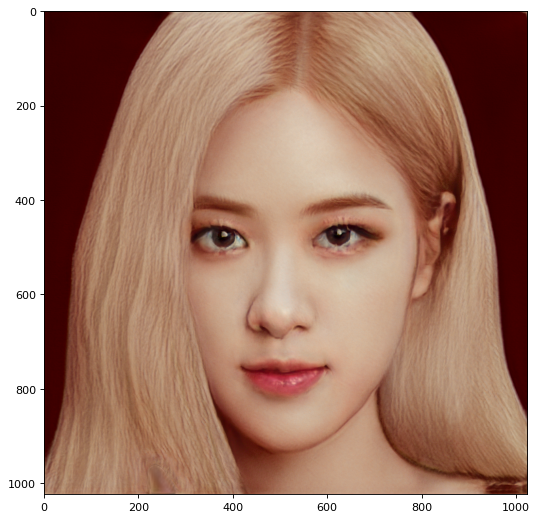

In [135]:
generated_image = g_synthesis(latent_code_init)
generated_image = (generated_image + 1.0) / 2.0
generated_image = generated_image.clamp(0, 1)
print(generated_image.shape)
imshow(generated_image)

### **CLIP Loss 정의**

In [126]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-pgccc9o3
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-pgccc9o3


In [127]:
import clip
import torch.nn as nn

class CLIPLoss(nn.Module):
    def __init__(self):
        super(CLIPLoss, self).__init__()
        self.model, self.preprocess = clip.load("ViT-B/32")
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=32)
    
    def forward(self, image, text):
        image = self.avg_pool(self.upsample(image)) # (1, 3, 224, 224)
        similarity = 1 - self.model(image, text)[0] / 100
        return  similarity

### **Latent Optimization**

In [136]:
from argparse import Namespace


args = Namespace()
args.description = 'really angry face' 
args.lr_rampup = 0.05  
args.lr = 0.1          # learning rate
args.step = 150        # Updata step  
args.l2_lambda = 0.005 # The weight for similarity to the original image.
args.save_intermediate_image_every = 10
args.results_dir = 'StyleCLIP_results'

In [137]:
import os
import math
import torchvision
from torch import optim


# The learning rate adjustment function.
def get_lr(t, initial_lr, rampdown=0.50, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp

text_inputs = torch.cat([clip.tokenize(args.description)]).to(device) # clip에 들어가는 text 토큰화 -> text
#os.makedirs(args.results_dir, exist_ok=True) 처음에 한번만 실행

# Initialize the latent vector to be updated.
latent = latent_code_init.detach().clone()
latent.requires_grad = True

clip_loss = CLIPLoss()
optimizer = optim.Adam([latent], lr=args.lr)

In [138]:
os.chdir('/content/gdrive/MyDrive/StyleGAN_Project/StyleCLIP_results')
os.makedirs(img_name + '_' + args.description, exist_ok=True)

In [139]:
os.makedirs(img_name + '_' + args.description, exist_ok=True)

for i in range(args.step):
    # Adjust the learning rate.
    t = i / args.step
    lr = get_lr(t, args.lr) # step 마다 learning rate update
    optimizer.param_groups[0]["lr"] = lr

    # Generate an image using the latent vector.
    img_gen = g_synthesis(latent)
    img_gen = (img_gen + 1.0) / 2.0
    img_gen = img_gen.clamp(0, 1)

    # Calculate the loss value.
    c_loss = clip_loss(img_gen, text_inputs)
    l2_loss = ((latent_code_init - latent) ** 2).sum()
    loss = c_loss + args.l2_lambda * l2_loss

    # Get gradient and update the latent vector.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log the current state.
    print(f"lr: {lr}, loss: {loss.item():.4f}")
    if args.save_intermediate_image_every > 0 and i % args.save_intermediate_image_every == 0:
        with torch.no_grad():
            img_gen = g_synthesis(latent)
            img_gen = (img_gen + 1.0) / 2.0
            img_gen = img_gen.clamp(0, 1)

        torchvision.utils.save_image(img_gen, os.path.join(img_name + '_' + args.description, img_name + '_' + args.description + f"{str(i).zfill(5)}.png"))

with torch.no_grad():
    img_orig = g_synthesis(latent_code_init)
    img_orig = (img_orig + 1.0) / 2.0
    img_orig = img_orig.clamp(0, 1)

# Display the initial image and result image.
final_result = torch.cat([img_orig, img_gen])
torchvision.utils.save_image(final_result.detach().cpu(), os.path.join(img_name + '_' + args.description, "final_result.jpg"))

lr: 0.0, loss: 0.7803
lr: 0.013333333333333334, loss: 0.7812
lr: 0.02666666666666667, loss: 0.7676
lr: 0.04, loss: 0.7725
lr: 0.05333333333333334, loss: 0.7822
lr: 0.06666666666666667, loss: 0.7812
lr: 0.08, loss: 0.7754
lr: 0.09333333333333334, loss: 0.7900
lr: 0.1, loss: 0.8052
lr: 0.1, loss: 0.8237
lr: 0.1, loss: 0.8276
lr: 0.1, loss: 0.8208
lr: 0.1, loss: 0.8052
lr: 0.1, loss: 0.8042
lr: 0.1, loss: 0.8071
lr: 0.1, loss: 0.7964
lr: 0.1, loss: 0.7871
lr: 0.1, loss: 0.7822
lr: 0.1, loss: 0.7749
lr: 0.1, loss: 0.7720
lr: 0.1, loss: 0.7681
lr: 0.1, loss: 0.7656
lr: 0.1, loss: 0.7578
lr: 0.1, loss: 0.7661
lr: 0.1, loss: 0.7637
lr: 0.1, loss: 0.7583
lr: 0.1, loss: 0.7534
lr: 0.1, loss: 0.7695
lr: 0.1, loss: 0.7676
lr: 0.1, loss: 0.7686
lr: 0.1, loss: 0.7656
lr: 0.1, loss: 0.7632
lr: 0.1, loss: 0.7578
lr: 0.1, loss: 0.7583
lr: 0.1, loss: 0.7534
lr: 0.1, loss: 0.7490
lr: 0.1, loss: 0.7568
lr: 0.1, loss: 0.7573
lr: 0.1, loss: 0.7588
lr: 0.1, loss: 0.7549
lr: 0.1, loss: 0.7559
lr: 0.1, loss: 

### **Visulalization**

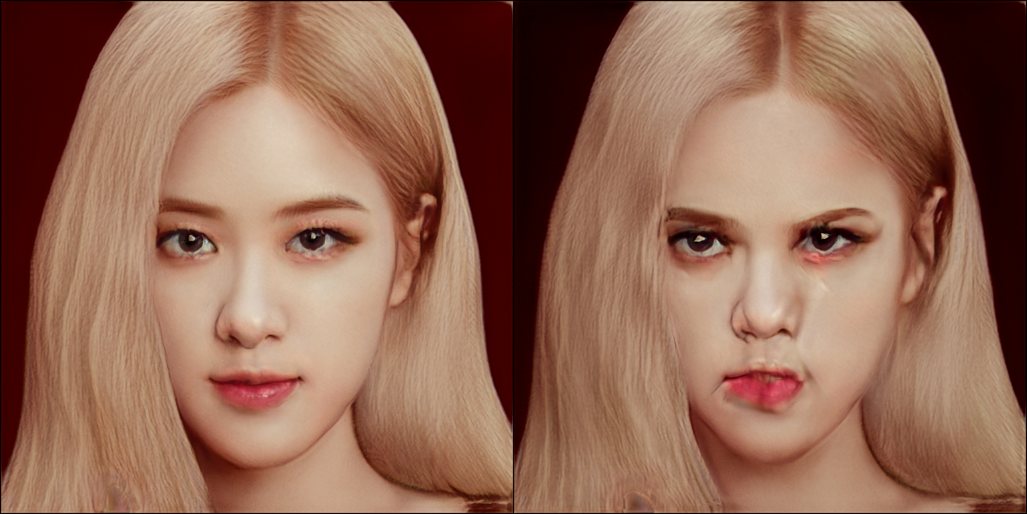

In [140]:
# Display the initial image and result image.
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

result_image = ToPILImage()(make_grid(final_result.detach().cpu()))
h, w = result_image.size
result_image.resize((h // 2, w // 2))